# Setting up environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import Imputer
import copy
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.tools.plotting import autocorrelation_plot
import math
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from datetime import timedelta
#from pyramid.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# To determine p and q parameters using ACF and PACF plots

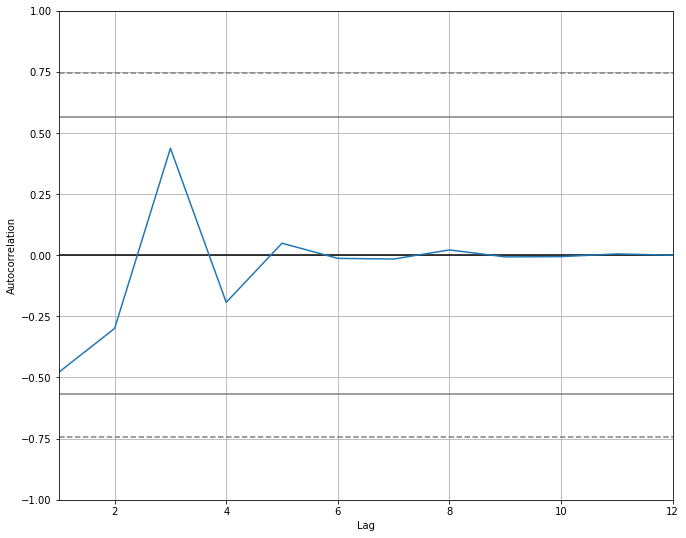

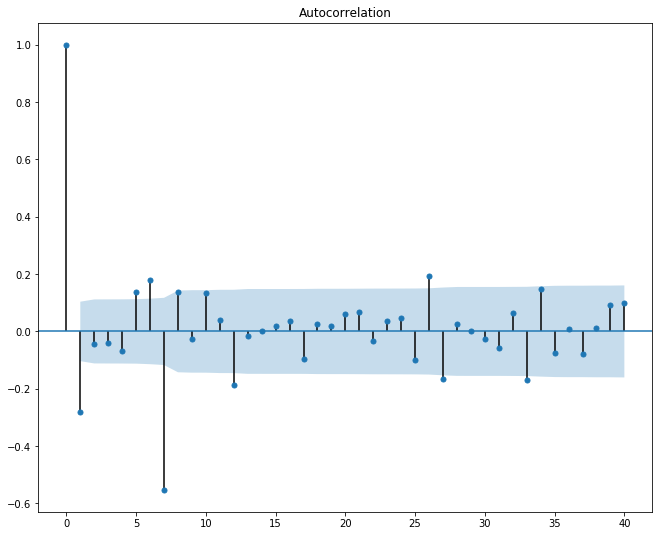

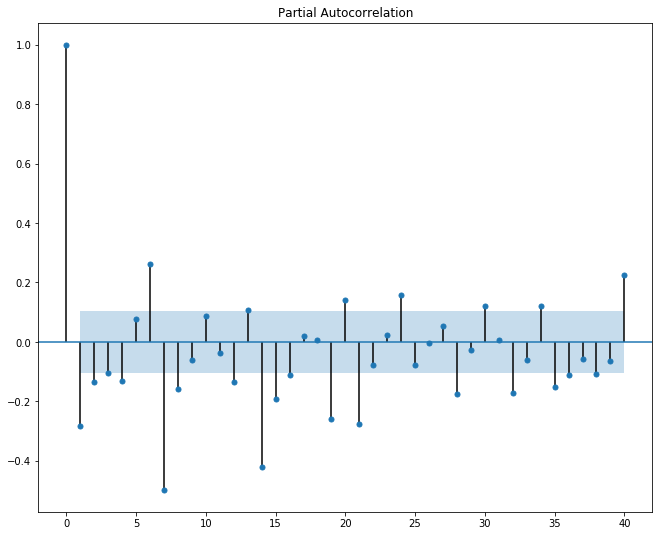

In [3]:
from data_preprocessing import differenced_series 
from data_preprocessing import interpolated_data 

# The function is defined to determine 'p' and 'q' for all the 9 countries.
def ar_ma_order (country):
    autocorrelation_plot(country.resample('M').mean())
    plot_acf(country, lags=40)
    plot_pacf(country, lags=40)
    
ar_ma_order(differenced_series['Arrivals to Austria'])  # ACF and PACF plots for Austria

# ARIMA function

In [4]:
train_size = int(len(interpolated_data) * 0.8) # Taking Training size as 80% of the total length
test_size = len(interpolated_data) - train_size
train = interpolated_data['Arrivals to Austria'][:train_size]
test = interpolated_data['Arrivals to Austria'][train_size:]

def arima_forecast(country, p, d, q):
    predicted = list()
    train = country[:train_size]
    test = country[train_size:]
    model = ARIMA(train, order=(p,d,q))
    model_fit = model.fit(disp=-1)
    predicted = model_fit.forecast(steps=4)[0]
    return (predicted)

# AR FIT model for Austria

                               ARIMA Model Results                               
Dep. Variable:     D.Arrivals to Austria   No. Observations:                  284
Model:                    ARIMA(3, 1, 0)   Log Likelihood               -2328.830
Method:                          css-mle   S.D. of innovations            880.843
Date:                   Wed, 04 Sep 2019   AIC                           4667.660
Time:                           18:37:32   BIC                           4685.905
Sample:                       10-02-2015   HQIC                          4674.975
                            - 07-11-2016                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -15.8795     32.285     -0.492      0.623     -79.158      47.399
ar.L1.D.Arrivals to Austria    -0.2926      0.059     -4

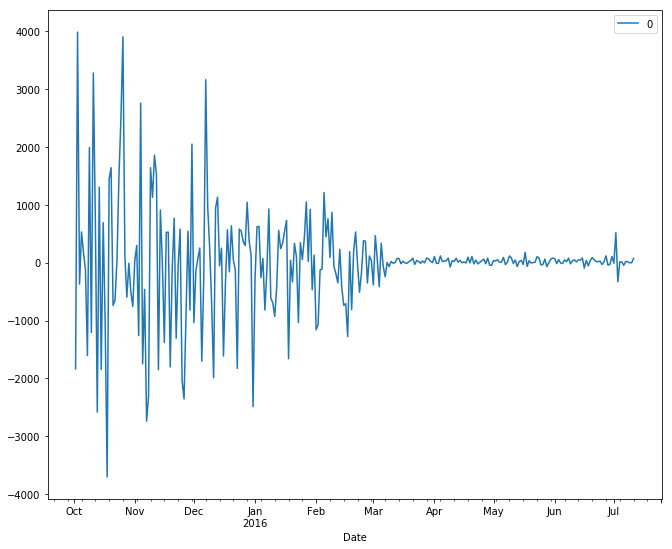

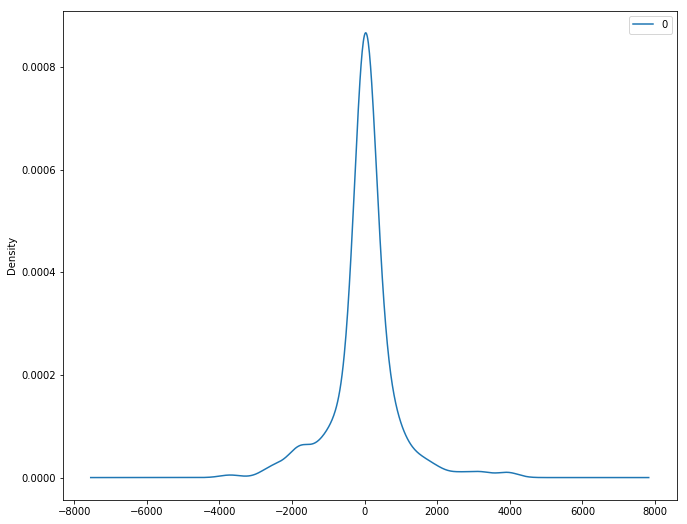

                 0
count   284.000000
mean      0.770593
std     884.394615
min   -3703.269767
25%     -79.047072
50%      21.546311
75%     117.261911
max    3984.817271


In [5]:
model = ARIMA(interpolated_data['Arrivals to Austria'][:train_size], order=(3,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show(90,90)
print(residuals.describe())

### Initially the refugee count for Austria is predicted using only base models such as
1. AR model
2. ARMA model

# AR model for Austria

In [70]:
predicted_series_ar = copy.deepcopy(interpolated_data)
predicted_series_ar[train_size:] = 0
predictions = arima_forecast(interpolated_data['Arrivals to Austria'], 3, 1, 0)
for i in range(0,4): predicted_series_ar['Arrivals to Austria'][train_size + i] =  predictions[i]
mse = mean_squared_error(test[:4], predictions)
print ('RMSE value: ',math.sqrt(mse))


RMSE value:  47.91250941952006


# ARMA model for Austria

In [7]:
predicted_series_arma = copy.deepcopy(interpolated_data)
predicted_series_arma[train_size:] = 0
predictions = arima_forecast(differenced_series['Arrivals to Austria'], 3, 0, 9)
for i in range(0,4): 
    predicted_series_arma['Arrivals to Austria'][train_size + i] =  predictions[i]
    

# Converting differenced series back to original series using de-differencing
def cumsum_seasonality(shift, country):
    temp2 = copy.deepcopy(country)
    for i in range(shift*2, len(country)):
        sum = 0
        if (i%2 != 0):
            for j in range(i%shift, i+1, shift):
                sum += country[j]
        if (i%2 == 0):
            for j in range(i%shift, i+1, shift):
                sum += country[j]

        temp2[i] = sum
    return temp2

predicted_series_arma['Arrivals to Austria'][train_size:] = cumsum_seasonality(7,predicted_series_arma['Arrivals to Austria'][train_size:]).cumsum()

mse = mean_squared_error(test[:4], predicted_series_arma['Arrivals to Austria'][train_size:train_size+4])
print ('RMSE value: ',math.sqrt(mse))

RMSE value:  170.77543734389909


# ARIMA FIT for Austria

                               ARIMA Model Results                               
Dep. Variable:     D.Arrivals to Austria   No. Observations:                  284
Model:                    ARIMA(3, 1, 4)   Log Likelihood               -2313.537
Method:                          css-mle   S.D. of innovations            833.506
Date:                   Wed, 28 Aug 2019   AIC                           4645.073
Time:                           19:41:18   BIC                           4677.914
Sample:                       10-02-2015   HQIC                          4658.240
                            - 07-11-2016                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -18.7765     15.150     -1.239      0.216     -48.470      10.917
ar.L1.D.Arrivals to Austria    -0.2697      0.219     -1

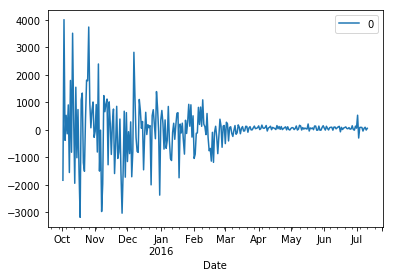

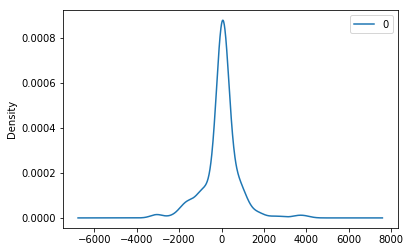

                 0
count   284.000000
mean      7.481210
std     842.808084
min   -3175.228694
25%    -117.468969
50%      64.219472
75%     175.217596
max    3997.628475


In [22]:
model = ARIMA(interpolated_data['Arrivals to Austria'][:train_size], order=(3,1,4))
model_fit = model.fit(disp=0)
print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show(90,90)
print(residuals.describe())

# ARIMA model for Austria

In [8]:
predicted_series_arima = copy.deepcopy(interpolated_data)
predicted_series_arima[train_size:] = 0
predictions = arima_forecast(interpolated_data['Arrivals to Austria'], 3, 1, 4)
for i in range(0,4): predicted_series_arima['Arrivals to Austria'][train_size + i] =  predictions[i]
mse = mean_squared_error(test[:4], predictions)
print ('RMSE value: ',math.sqrt(mse))


#arima_forecast(interpolated_data['Arrivals to Slovenia'], 2, 1, 1)
#arima_forecast(interpolated_data['Arrivals to Hungary'], 3, 1, 2)

RMSE value:  112.8959926293655


# Rolling Forecast models for ARMA, ARIMA and SARIMA

Using the above AR, ARMA and ARIMA models, the refugee count can be predicted accurately for only following 2 - 3 days. Hence Rolling forecast model is employed in order to increase the prediction days and also to increase the accuracy of the model.

## ARIMA Rolling forecast model - Austria

In [55]:
def arima_rolling_forecast(country, order, train_size = 285):

    train = country[:train_size]
    test = country[train_size:]
    history = [x for x in train]
    predictions_f = list()

    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=-1)
        yhat_f = model_fit.forecast()[0][0]
        predictions_f.append(yhat_f)
        history.append(test[t])
    return predictions_f

predictions_f = arima_rolling_forecast(interpolated_data['Arrivals to Austria'], (4,1,1))

train_size = int(len(interpolated_data) * 0.8) 
predicted_series_arima_rolling = copy.deepcopy(interpolated_data)
predicted_series_arima_rolling[train_size:] = 0
predicted_series_arima_rolling['Arrivals to Austria'][train_size:] = predictions_f
mse = mean_squared_error(test, predictions_f)
print ('RMSE value: ',math.sqrt(mse))

RMSE value:  48.33216339395736


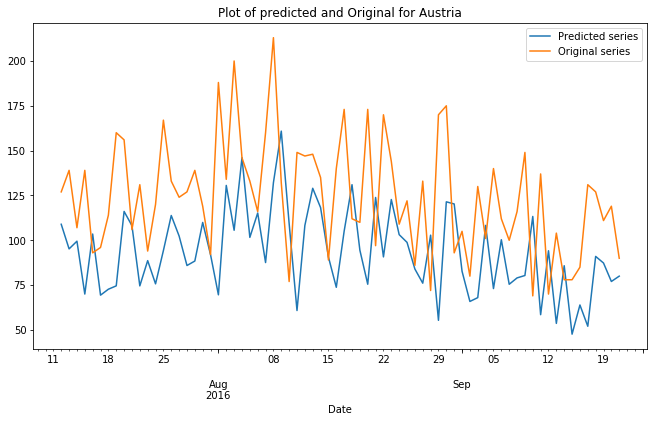

In [56]:
rcParams['figure.figsize'] = 11, 6
predicted_series_arima_rolling['Arrivals to Austria'][train_size:].plot()
interpolated_data['Arrivals to Austria'][train_size:].plot()
plt.legend(['Predicted series','Original series'])
plt.title('Plot of predicted and Original for Austria')
plt.show()

## ARMA Rolling Forecast Model - Austria

In [59]:
def arma_rolling_forecast(country, order, train_size = 285):
    predictions_f = arima_rolling_forecast(country, order)
    train_size = int(len(differenced_series) * 0.8) 
    predicted_series_arma_rolling[train_size:] = 0
    predicted_series_arma_rolling['Arrivals to Austria'][train_size:] = predictions_f
    return (predictions_f)


    
predicted_series_arma_rolling = copy.deepcopy(interpolated_data)    
predictions_f = arma_rolling_forecast(interpolated_data['Arrivals to Austria'], (3,0,5))
test = interpolated_data['Arrivals to Austria'][train_size:]
mse = mean_squared_error(test, predictions_f)
print ('RMSE value: ',math.sqrt(mse))

RMSE value:  51.06232552334552


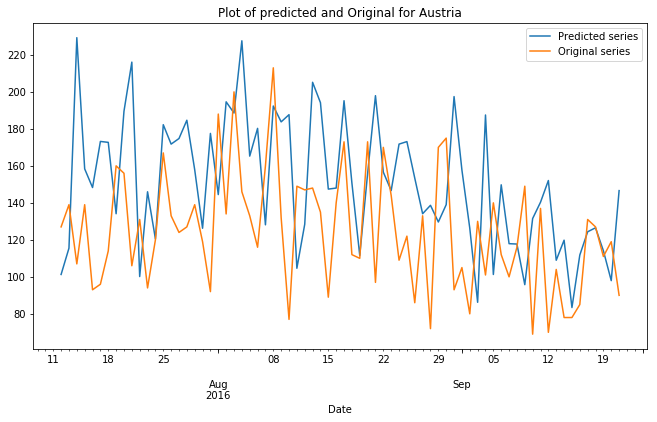

In [60]:
predicted_series_arma_rolling['Arrivals to Austria'][train_size:].plot()
interpolated_data['Arrivals to Austria'][train_size:].plot()
plt.legend(['Predicted series','Original series'])
plt.title('Plot of predicted and Original for Austria')
plt.show()

## SARIMA Rolling Forecast Model - Austria

In [27]:
def sarima_rolling_forecast(country, order, train_size = 285):
    
    train, test = country[0:train_size], country[train_size:]
    history = [country for country in train]
    predictions_f = list()
    exp = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=order, seasonal_order=(1,0,0,1))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions_f.append(yhat)
        obs = test[t]
        exp.append(obs)
        history.append(obs)
    return(predictions_f)



predictions_f = sarima_rolling_forecast(interpolated_data['Arrivals to Austria'], (5,1,2))
predicted_series_sarima_rolling = copy.deepcopy(interpolated_data)
predicted_series_sarima_rolling['Arrivals to Austria'][train_size:] = predictions_f
test = interpolated_data['Arrivals to Austria'][train_size:]
mse = mean_squared_error(test, predictions_f)
print ('RMSE value: ',math.sqrt(mse))

RMSE value:  37.68381397432872


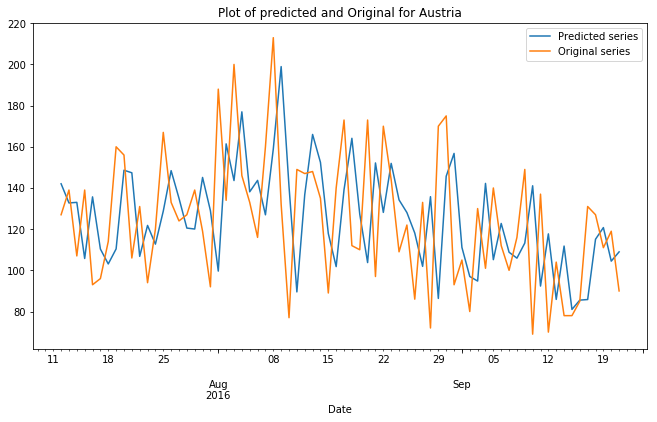

In [26]:
predicted_series_sarima_rolling['Arrivals to Austria'][train_size:].plot()
interpolated_data['Arrivals to Austria'][train_size:].plot()
plt.legend(['Predicted series','Original series'])
plt.title('Plot of predicted and Original for Austria')
plt.show()
